# Detection and Translation using whisper

In [2]:
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline


device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-medium"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)


result = pipe("my_audio.wav", generate_kwargs={"task": "translate"})
print(result["text"])


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=translate, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=translate.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 1 2 3 4 5 6


# Speech to Text using web api

In [3]:
pipe("guj.mp3", generate_kwargs={"task": "translate"})

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:496: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


{'text': " Gujarat's education and advanced state-of-the-art culture are of vital importance in India's cultural heritage. Gujaratis have made it an important community in their independence and unity."}

In [ ]:
!pip install speechrecognition ffmpeg-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 23.9 MB/s eta 0:00:00


### Using ffmpeg we are enabling the system's microphone to record audio

- We are using the javascript to access the recorder of the system.
- Running it for some defined no. of seconds.
- Saving the audio file as my_audio.wav


In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record_audio(sec=5):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  return b

In [ ]:
import ffmpeg

def save_as_wav(audio_data, filename="audio.wav"):
  # Create a process for converting the audio data to wav format
  process = (
      ffmpeg
      .input('pipe:', format='webm')  # Input is raw WebM data
      .output(filename, format='wav', acodec='pcm_s16le', ac=1, ar='16k')  # Output to wav with specific settings
      .overwrite_output()  # Allow overwriting existing files
      .run_async(pipe_stdin=True)  # Run asynchronously with input from pipe
  )

  # Feed the audio data to the process
  process.stdin.write(audio_data)
  process.stdin.close()
  process.wait()  # Wait for the process to complete

In [ ]:
# Record audio for 10 seconds
audio_data = record_audio(5)
# Save the audio as "audio.wav"
save_as_wav(audio_data, "my_audio.wav")

<IPython.core.display.Javascript object>

In [ ]:
import speech_recognition as sr
def speech_to_text(audio):
      recognizer = sr.Recognizer()
      with sr.AudioFile(audio) as source:
          audio = recognizer.record(source)
          try:
              text = recognizer.recognize_google(audio, language='hi-IN')
              print("Transcribed Text : ", text)
              return text
          except sr.UnknownValueError:
              print("Could not understand audio")
              return ""

In [ ]:
text = speech_to_text("my_audio.wav")

Transcribed Text :  एक व्यक्ति हवा में उड़ रहा है


# Speech to Text Translate using Sarvam.ai Api

In [ ]:
import requests

def transcribe_audio(api_key, audio_file_path, model="saaras:v1"):
    """Transcribes an audio file using Sarvam.ai Speech-to-Text-Translate API.

    Args:
        api_key: Your Sarvam.ai API subscription key.
        audio_file_path: Path to the audio file.
        model: The speech recognition model to use (default: saaras:v1).

    Returns:
        A dictionary containing the transcribed text and timestamps, if successful.
    """

    url = "https://api.sarvam.ai/speech-to-text-translate"
    headers = {
        "api-subscription-key": api_key,
        # "Content-Type": "multipart/form-data"  # This is automatically set by requests
    }

    with open(audio_file_path, "rb") as audio_file:
        files = {"file": (audio_file_path, audio_file, "audio/wav")}  # Create file data
        data = {"model": model}

        response = requests.post(url, headers=headers, data=data, files=files)

        if response.status_code == 200:
            return response.json()  # Assuming JSON response
        else:
            print(f"Error: {response.status_code} - {response.text}")
            return None

from google.colab import userdata
api_key = userdata.get('SARVAM_API')

audio_file_path = "my_audio.wav"
result = transcribe_audio(api_key, audio_file_path)

if result:
    print("Transcription:", result.get("transcript"))

Transcription: A person is flying in the air.


In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to(device)
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
            "CompVis/stable-diffusion-v1-4",
            torch_dtype=torch.float16,
        )
img2img_pipe = img2img_pipe.to(device)

# Define a function to generate an image
def generate_image(prompt, image=None):
    if image is None:

        image = pipe(prompt).images[0]
    else:

        image = img2img_pipe(prompt, image=image).images[0]
    return image

# Set the device to CUDA if available

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter the prompt: raining in forest


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as image.png


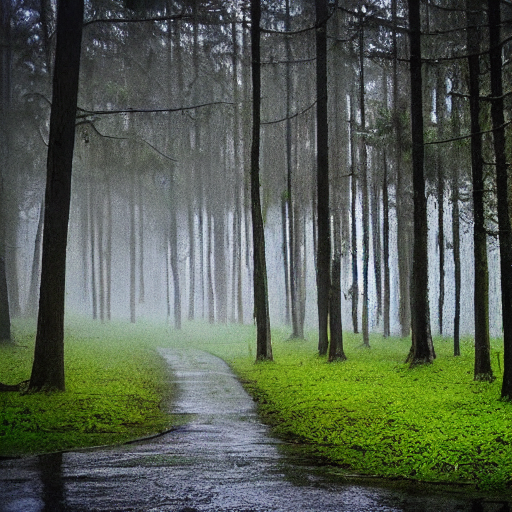

Do you want to generate another image? (y/n): y
Enter the prompt: place a man in the given image


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as image.png


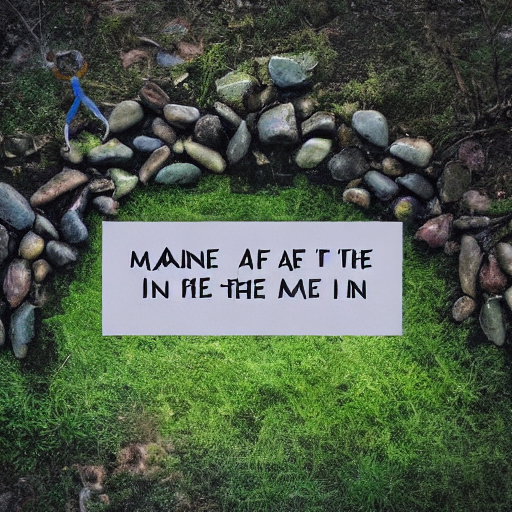

Do you want to generate another image? (y/n): y
Enter the prompt: raining and dog playing


  0%|          | 0/40 [00:00<?, ?it/s]

Image saved as image.png


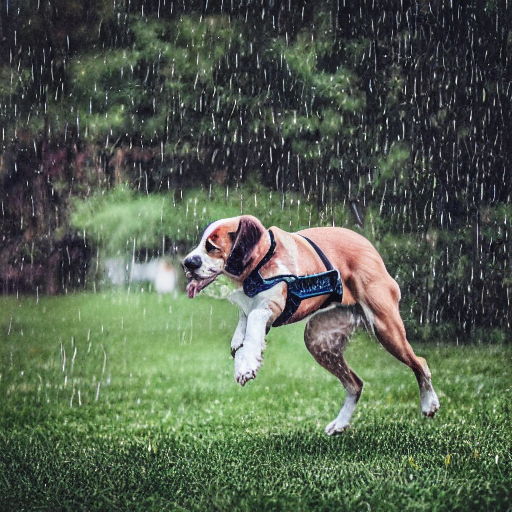

Do you want to generate another image? (y/n): n


In [ ]:
from IPython.display import Image

first_image=None

while True:
    prompt = input("Enter the prompt: ")
    image = generate_image(prompt, first_image)
    image.save("image.png")
    print("Image saved as image.png")
    display(Image("image.png"))

    # Ask the user if they want to generate another image
    response = input("Do you want to generate another image? (y/n): ")
    if response.lower()!= "y":
        first_image=None
        break

    # Update the first image
    first_image = image
